In [1]:
from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
import os
from tqdm import tqdm

from cell_inference.config import paths, params
from cell_inference.cells.simulation import Simulation
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.utils.random_parameter_generator import generate_predicted_parameters_from_config
from cell_inference.utils.transform.geometry_transformation import unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import process_lfp, scaled_stats_indices

h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY_REDUCED_ORDER)
h.tstop = params.TSTOP
h.dt = params.DT
h.steps_per_ms = 1/h.dt

geo_standard = pd.read_csv(paths.GEO_REDUCED_ORDER, index_col='id')

## Load data

#### In vivo data

In [2]:
invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikeWaveforms_NP_SUTempFilter_NPExample'
# invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikes_NPUnits_large.h5'

INVIVO_PATH = 'cell_inference/resources/invivo'
INVIVO_LFP_PATH = os.path.join(INVIVO_PATH, 'lfp_' + invivo_name + '.npz')  # LFP and labels
INVIVO_STATS_PATH = os.path.join(INVIVO_PATH, 'summ_stats_' + invivo_name + '.npz')  # summary statistics

invivo_stats = np.load(INVIVO_STATS_PATH)['x']
layer = np.load(INVIVO_STATS_PATH)['layer']
y_c = np.load(INVIVO_STATS_PATH)['yc']

#### Simulation data

In [3]:
DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'Reduced_Order_trunkLR_Loc5_restrict_h') # select trial

STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats.npz')  # summary statistics
STATS = np.load(STATS_PATH)
sim_stats = STATS['x']
n_sim_stats = sim_stats.shape[1]

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
ranges = config_dict['Simulation_Parameters']['loc_param_range']
ranges.update(config_dict['Simulation_Parameters']['geo_param_range'])

print(inference_list)

['y', 'd', 'theta', 'h', 'phi', 'l_t', 'r_t']


### Transform labels

#### Orientation

In [4]:
check_orient = 'h' in inference_list and 'phi' in inference_list
if check_orient:
    orient_idx0 = [inference_list.index(x) for x in ['h', 'phi']]
#     orient_idx2 = orient_idx0.copy()

direction_vec = True # represent orientation by vector on unit sphere
direction_vec = direction_vec and check_orient

label_list = inference_list.copy()
if direction_vec:
    orient_idx1 = list(range(len(inference_list) - 2, len(inference_list) + 1))
#     orient_idx2 = [orient_idx1[1], len(inference_list) + 1]
    label_list.remove('h')
    label_list.remove('phi')
    label_list += ['vx', 'vy', 'vz']
    for i in orient_idx1:
        ranges[label_list[i]] = [-1., 1.]

display_list = label_list.copy()
if direction_vec:
    display_list[orient_idx1[1]] = 'vy / h'
    display_list.append('phi')

#### y shift

In [5]:
has_yshift = 'y' in label_list
if has_yshift:
    ys_idx = label_list.index('y')
    label_list[ys_idx] = 'ys'
    display_list[display_list.index('y')] = 'y-shift'
    ranges['ys'] = [-150, 150] # set bound for normalization

#### Normalization

In [6]:
feature_range = (-1, 1)
norm_scale = lambda x, r: (x - r[0]) / (r[1] - r[0]) * (feature_range[1] - feature_range[0]) + feature_range[0]
org_scale = lambda x, r: (x - feature_range[0]) / (feature_range[1] - feature_range[0]) *  (r[1] - r[0]) + r[0]

### Get magnitude distribution

In [7]:
scaled_idx = scaled_stats_indices()
max_mag_idx = [33, 38]
max_mag = np.amax(sim_stats[:, max_mag_idx], axis=1)
max_mag_invivo = np.amax(invivo_stats[:, max_mag_idx], axis=1)
mag_scale = np.mean(max_mag) / np.mean(max_mag_invivo)
invivo_stats_scaled = invivo_stats.copy()
invivo_stats_scaled[:, scaled_idx] *= mag_scale
print(mag_scale)

0.07519359893711132


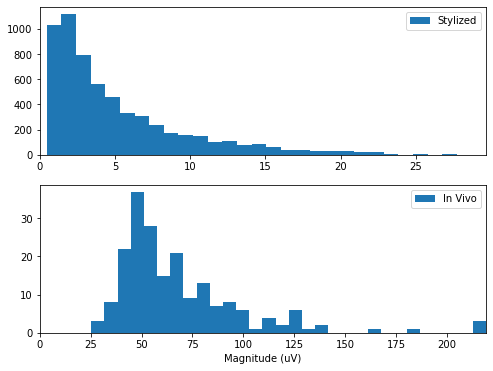

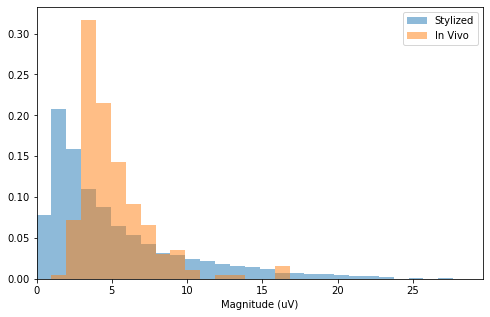

In [8]:
nbins = 30

plt.figure(figsize=(8, 6))
plt.subplot(211)
_, bins, _ = plt.hist(max_mag, bins=nbins, label='Stylized')
plt.xlim([0,bins[-1]])
plt.legend()
plt.subplot(212)
_, bins, _ = plt.hist(max_mag_invivo, bins=nbins, label='In Vivo')
plt.xlim([0,bins[-1]])
plt.legend()
plt.xlabel('Magnitude (uV)')

bins = np.linspace(0, max(np.amax(max_mag), np.amax(mag_scale * max_mag_invivo)), nbins + 1)
plt.figure(figsize=(8, 5))
plt.hist(max_mag, bins=bins, label='Stylized', density=True, alpha=0.5)
plt.hist(mag_scale * max_mag_invivo, bins=bins, label='In Vivo', density=True, alpha=0.5)
plt.xlim([0, bins[-1]])
plt.legend()
plt.xlabel('Magnitude (uV)')
plt.show()

## Load model

In [9]:
import torch
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
# from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork

model_name = 'FCN_batch256' # select model
if direction_vec:
    model_name += '_dv'
model_name += '.pth'
MODEL_PATH = os.path.join(TRIAL_PATH, model_name)

model = FullyConnectedNetwork(in_features=n_sim_stats, out_features=len(label_list))
model.load_state_dict(torch.load(MODEL_PATH))
device = torch.device("cpu")
model.eval()

FullyConnectedNetwork(
  (hidden_layers): Sequential(
    (0): Linear(in_features=72, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=124, bias=True)
    (3): ReLU()
    (4): Linear(in_features=124, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
  )
  (output_layers): Linear(in_features=16, out_features=8, bias=True)
)

### Predict on in vivo data

In [10]:
pred = model(torch.Tensor(invivo_stats_scaled).to(device)).to("cpu").detach().numpy()
for i, lb in enumerate(label_list):
    pred[:, i] = org_scale(pred[:, i], ranges[lb])
pred_list = label_list.copy()
pred_list = label_list.copy()
if has_yshift:
    pred[:, ys_idx] = y_c - pred[:, ys_idx]
    pred_list[pred_list.index('ys')] = 'y'
if direction_vec:
    pred[:, orient_idx1] = trivarnorm2unitsphere(pred[:, orient_idx1])
    pred = np.hstack([pred, unitsphere2hphi(pred[:, orient_idx1])[:, [1]]])
    pred_list[pred_list.index('vy')] = 'h'
    pred_list.append('phi')
pred_dict = dict(zip(pred_list, pred.T))
pred_dict['layer'] = layer

In [11]:
df_pred = pd.DataFrame(pred_dict).sort_values(by='y')

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_pred)

,y,d,theta,l_t,r_t,vx,h,vz,phi,layer
167,-1010.932251,124.144852,-0.441790,770.103333,0.398940,-0.141758,0.704236,-0.695669,-2.940573,Layer6
174,-996.503479,212.381866,0.169224,504.904327,0.670052,0.103392,0.702893,-0.703741,2.995719,Layer6
163,-993.565125,141.034714,0.159690,1414.368042,0.579509,0.190358,0.892120,-0.409739,2.706678,Layer6
7,-977.675293,135.046295,0.227058,859.619507,0.545049,0.206429,0.740394,-0.639690,2.829441,Layer6
8,-961.913696,161.053879,0.054689,647.362000,0.575839,0.163236,0.804516,-0.571058,2.863170,Layer6
4,-960.760376,156.875793,-0.063238,1268.111816,0.669082,-0.074366,0.828526,-0.554990,-3.008390,Layer6
0,-958.410828,136.024307,-0.218443,1367.243774,0.493043,0.091882,0.752605,-0.652030,3.001597,Layer6
127,-957.906982,141.624313,0.136184,1107.227539,0.454566,0.224100,0.852420,-0.472398,2.698643,Layer6
168,-955.612183,135.835480,0.058462,1087.325439,0.482796,0.178177,0.855500,-0.486181,2.790309,Layer6
1,-948.167969,92.518120,-0.229786,865.155518,0.425856,0.058844,0.755107,-0.652956,3.051716,Layer6


Text(0, 0.5, 'trunk_length')

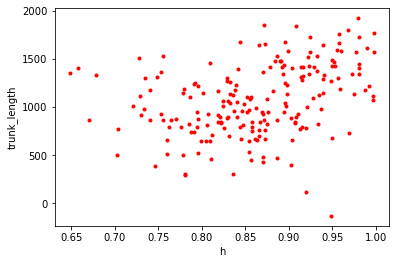

In [12]:
plt.figure()
plt.plot(pred_dict['h'], pred_dict['l_t'], 'r.')
plt.xlabel('h')
plt.ylabel('trunk_length')

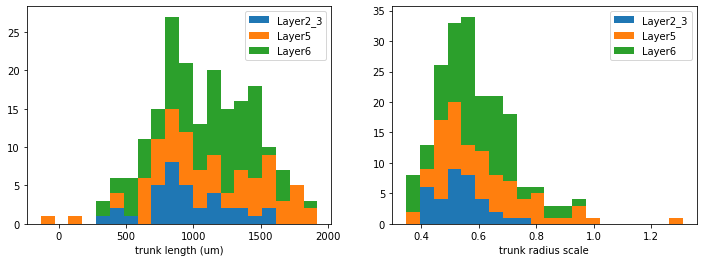

In [13]:
layer_type = np.unique(layer)
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist([pred_dict['l_t'][layer==ly] for ly in layer_type], bins=20, label=layer_type, stacked=True)
plt.xlabel('trunk length (um)')
plt.legend()
plt.subplot(122)
plt.hist([pred_dict['r_t'][layer==ly] for ly in layer_type], bins=20, label=layer_type, stacked=True)
plt.xlabel('trunk radius scale')
plt.legend()
plt.show()

## Simulate with predicted parameters

#### Whether run simulation

In [14]:
simulate_prediction = False

if simulate_prediction:
    if config_dict['Simulation_Parameters']['gmax_mapping'] is None:
        gmax = config_dict['Simulation_Parameters']['gmax']
    else:
        pass # TODO
    stim_param = config_dict['Simulation_Parameters']['stim_param']

    # Biophysical parameters
    filepath = config_dict['Simulation_Parameters']['full_biophys']
    with open(filepath) as f:
        full_biophys = json.load(f)

    # common parameters
    biophys_param = config_dict['Simulation_Parameters']['biophys_param']
    biophys_comm = config_dict['Simulation_Parameters']['biophys_comm']

    # whether use parameter interpreter
    interpret_params = config_dict['Simulation_Parameters']['interpret_params'] if 'interpret_params' in config_dict['Simulation_Parameters'].keys() else False

    number_locs = 1
    labels, rand_param, loc_param, geo_param = generate_predicted_parameters_from_config(config_dict, pred_dict, number_locs=number_locs)
    number_cells = geo_param.shape[0]
    number_samples = labels.shape[0]

    print(loc_param.shape)
    print(geo_param.shape)
    print(labels.shape)

### Create simulation and run

In [15]:
import time
import datetime

if simulate_prediction:
    timer_start = time.time()

    sim = Simulation(
        cell_type = CellTypes.REDUCED_ORDER,
        ncell = number_cells,
        geometry = geo_standard,
        electrodes = params.ELECTRODE_POSITION,
        loc_param = loc_param,
        geo_param = geo_param,
        biophys = biophys_param,
        full_biophys = full_biophys,
        biophys_comm = biophys_comm,
        gmax = gmax,
        stim_param = stim_param,
        interpret_params = interpret_params,
        min_distance = params.MIN_DISTANCE,
        record_soma_v = False,
        spike_threshold = params.SPIKE_THRESHOLD
    )

    sim.run_neuron_sim()

    print('Simulation run time: ' + str(datetime.timedelta(seconds=time.time() - timer_start)))

### Get LFPs
#### Save what

In [16]:
save_lfp = True
save_stats = True

#### Remove cells with invalid firing pattern

In [17]:
if simulate_prediction:
    nspk, _ = sim.get_spike_number('all')

    valid = nspk==1
    invalid = np.nonzero(~valid)[0]
    invalid_nspk = nspk[invalid]
    for n in np.unique(invalid_nspk):
        print('%d cells fire %d times.' % (np.count_nonzero(invalid_nspk==n), n))

    invalid_params = {}
    invalid_params['geo_param'] = geo_param[invalid, :]
    invalid_params['gmax'] = sim.gmax[invalid]

    invalid_samples = (number_locs * invalid.reshape(-1,1) + np.arange(number_locs)).ravel()
    number_samples -= invalid_samples.size
    labels = np.delete(labels, invalid_samples, axis=0)
    rand_param = np.delete(rand_param, invalid_samples, axis=0)
    gmax = np.repeat(sim.gmax[valid], number_locs)

#### Reshape LFP array. Filter each channel. Get window of spike for each sample.

In [18]:
if simulate_prediction:
    timer_start = time.time()

    lfp = sim.get_lfp('all', multiple_position=True)[valid]  # (cells x locs x channels x time)

    print('LFP run time: ' + str(datetime.timedelta(seconds=time.time() - timer_start)))

    lfp = lfp.reshape((-1,)+lfp.shape[-2:]).transpose((0,2,1))  # -> (samples x channels x time) -> (samples x time x channels)

    start_idx = int(max(np.ceil(stim_param['start']/h.dt) - params.PK_TR_IDX_IN_WINDOW, 0)) # ignore signal before
    pad_spike_window = False
    bad_cases = tuple(range(-1,3)) if pad_spike_window else tuple(range(3))
    if 'y' in inference_list:
        y_idx = inference_list.index('y')
        ycoord = lambda i: labels[i, y_idx]
    else:
        ycoord = lambda i: None

    bad_indices = {bad: [] for bad in bad_cases}
    lfp_list = []
    yshift = []
    summ_stats = []
    good_count = 0

    for i in tqdm(range(number_samples)):
        bad, g_lfp, _, _, _, ys, ss = process_lfp(
            lfp[i,start_idx:,:], dt=None, ycoord=ycoord(i), gauss_filt=True,
            calc_summ_stats=save_stats, additional_stats=3, err_msg=True
        )
        bad_indices[bad].append(i)
        if bad<=0:
            good_count += 1
            lfp_list.append(g_lfp)
            yshift.append(ys)
            if save_stats:
                summ_stats.append(ss)

    t = sim.t()[:params.WINDOW_SIZE]
    windowed_lfp = np.stack(lfp_list, axis=0)  # (samples x time window x channels)
    yshift = np.array(yshift)
    summ_stats = np.array(summ_stats)

    bad_idx = np.array([i for bad, indices in bad_indices.items() if bad>0 for i in indices])
    good_indices = np.sort([i for bad, indices in bad_indices.items() if bad<=0 for i in indices])
    print('%d good samples out of %d samples.' % (good_count, number_samples))
    for bad, indices in bad_indices.items():
        print('Bad case %d bad: %d samples.' % (bad, len(indices)))

### Save configurations and simulation data

In [19]:
PRED_LFP_PATH = os.path.join(TRIAL_PATH, 'lfp_pred')  # LFP and labels
PRED_STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats_pred')  # summary statistics

In [20]:
if simulate_prediction:
    if save_lfp:
        np.savez(PRED_LFP_PATH, t=t, x=windowed_lfp, y=labels, ys=yshift, rand_param=rand_param, gmax=gmax,
                 bad_indices=bad_indices, good_indices=good_indices, invalid_params=invalid_params,
                 valid=valid, invalid=invalid)
    if save_stats:
        np.savez(PRED_STATS_PATH, x=summ_stats, y=labels[good_indices], ys=yshift,
                 rand_param=rand_param[good_indices], gmax=gmax[good_indices])

## Evaluate prediction